# INM705 - Deep Learning for Image Analysis

Authors: Laerte Adami - Alperen Erol

In [1]:
#from Utilities.FCN.myFcn import my_fcn_resnet50

#FCN_weights = FCN_ResNet50_Weights.DEFAULT
#backbone_weights = ResNet50_Weights.DEFAULT
#mymodel = my_fcn_resnet50(backbone_weights=backbone_weights).to(device)

In [2]:
# https://github.com/goldbattle/pytorch_unet/blob/master/datasets.py

# Custom functionalities
from Utilities.metrics import meanPixelwiseAccuracy, meanIoU
from Utilities.datasetHandler import CityscapesDataset, visualise_and_save
from Utilities.modelHandler import modelFCN, modelUNet
from Utilities.unet import UNet
from Utilities.customLoss import DiceLoss
from Utilities.classHandler import CityscapesClass

import time
import torch
import torch.nn.functional as F
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')

torch.cuda.empty_cache()

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 17

## Data

In [3]:
### DATASET ###
classes = CityscapesClass("10 classes") # Pick a case: "4 classes", "6 classes", "10 classes"

img_directory = '/mnt/data/course/psarin/inm705/leftImg8bit'
ground_truth_directory = '/mnt/data/course/psarin/inm705/gtFine_trainvaltest/gtFine'
n_classes = len(classes.labels) 
resize_dimensions = (205,410)

dataset_args = {'image_directory' : img_directory,
                'gt_directory' : ground_truth_directory,
                'trainId' : classes.trainId,
                'colors' : classes.colors,
                'num_classes' : n_classes,
                'resize_dimensions' : resize_dimensions}

# Import datasets
dt_train = CityscapesDataset(phase = 'train', **dataset_args)

dt_val = CityscapesDataset(phase = 'val', **dataset_args)

dt_test = CityscapesDataset(phase = 'test', **dataset_args)

# Initialise dataloaders
dataloader_args = {'batch_size':64, 'shuffle':False}

## TRAIN dataset
trainloader = DataLoader(dt_train, **dataloader_args)
## VAL dataset
valloader = DataLoader(dt_val, **dataloader_args)
## TEST dataset
testloader = DataLoader(dt_test, batch_size=30)  

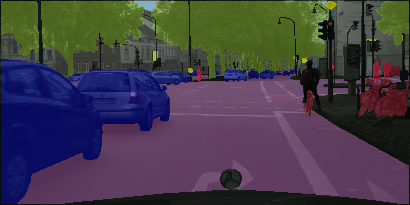

In [4]:
# Check dataset
X_viz, X_viz_norm = dt_train.get_image_visualization(10)
gt_mask = dt_train.get_ground_truth(10)
gt_mask = gt_mask.argmax(dim=0)

bool_masks = gt_mask == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.6, colors = dt_train.colors)
to_pil_image(sm)

## Model

### FCN

In [5]:
##MODEL Pretrained with RESNET 50
#Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT
#model = fcn_resnet50(backbone_weights=backbone_weights).to(device)
model = fcn_resnet50().to(device)

model.backbone.requires_grad_(True)
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.requires_grad_(True)

cel = CrossEntropyLoss()
ad = Adam(model.parameters(), lr = 1e-5, weight_decay = 1e-3)

fcn1 = modelFCN(model, loss_function=cel, optimizer = ad )
fcn1.model.to(device);

In [6]:
## TRAINING PHASE ##
training_name = "fcn_28_02_10classes"
start_time = time.time()

L = fcn1.train_model(trainloader, total_epochs=30, save_every_epochs = 6, ckp_name = training_name)

comp_time = time.time() - start_time
print("Computational time required: {}".format(comp_time))

fig, ax = plt.subplots()
ax.plot(L, linewidth = 3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");
plt.savefig(training_name+".png")

Completed epoch 1


Completed epoch 2


Completed epoch 3


Completed epoch 4


Completed epoch 5


Completed epoch 6


Completed epoch 7


Completed epoch 8


Completed epoch 9


### U-Net

##MODEL
model = UNet(enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=n_classes, retain_dim=True, out_sz=resize_dimensions)
#model = model.to(device)

cel = CrossEntropyLoss()
dl = DiceLoss()
ad = Adam(model.parameters(), lr=1e-5, weight_decay = 1e-3)

unet1 = modelUNet(model, loss_function=cel, optimizer = ad )
unet1.model.to(device);

t_start = time.time()

L = unet1.train_model(trainloader, total_epochs=10, save_every_epochs = 10, ckp_name="unet_10ep_25_02")

print("Training time: {} s".format(time.time()-t_start))

fig, ax = plt.subplots()
ax.plot(L)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss");

## Model validation

In [ ]:
def evaluate_model(valloader, modelHandler, ckp):
    
    # Load checkpoint
    modelHandler.model.load_state_dict(torch.load("Checkpoints/fcn_28_02_6classes_50.pth"))
    modelHandler.model.eval();
    # Step 4: Use the model and visualize the prediction
    fcn1.model.eval()
    _, X_test, y_test = next(iter(valloader))
    X_test, y_test = X_test.to(device), y_test.to(device) 

    fcn1.model.to(device)
    pred = fcn1.model(X_test)['out'] #METTILO PER FCN

    # Apply softmax and threshold value
    out = F.softmax(pred,dim=1)# > 0.5
    #out = out.int()
    out = torch.argmax(out, dim=1)
    
    # Computing metrics
    #print("Mean Pixelwise Accuracy: {}".format(round(meanPixelwiseAccuracy(out,y_test),2)))

    #print("Mean IoU: {}".format(round(meanIoU(out, y_test),3)))
    
    # return METRICS
    
    

In [ ]:
# Load checkpoint
fcn1.model.load_state_dict(torch.load("Checkpoints/fcn_28_02_6classes_50.pth"))
fcn1.model.eval();

# Step 4: Use the model and visualize the prediction
_, X_test, y_test = next(iter(valloader))
X_test, y_test = X_test.to(device), y_test.to(device) 

fcn1.model.to(device)
pred = fcn1.model(X_test)['out'] #METTILO PER FCN

# Apply softmax and threshold value
out = F.softmax(pred,dim=1)# > 0.5
#out = out.int()
out = torch.argmax(out, dim=1)

print("Output dimension: {}".format(out.size()))

In [ ]:
# Computing metrics
#print("Mean Pixelwise Accuracy: {}".format(round(meanPixelwiseAccuracy(out,y_test),2)))

#print("Mean IoU: {}".format(round(meanIoU(out, y_test),3)))

## Visualisation

In [ ]:
n_test = 8

X_viz, X_viz_norm = dt_val.get_image_visualization(n_test)
gt_viz = dt_val.get_ground_truth(n_test)
gt_viz = gt_viz.argmax(dim=0)

# Process the input with the model
pred_viz = fcn1.model(X_viz_norm.unsqueeze(0).to(device))['out'] #METTILO PER FCN

#out_viz = torch.sigmoid(pred_viz) > 0.5
#out_viz = out_viz.int()[0] # unpack the batch with [0]

out_viz = F.softmax(pred_viz,dim=1)# > 0.5
out_viz = torch.argmax(out_viz, dim=1)

# Create the mask with argmax
mask = out_viz#.argmax(dim=0)

In [ ]:
# Single class visualisation
class_id = 5
single_class_mask = (mask == class_id)

sm = draw_segmentation_masks(X_viz, masks=single_class_mask, alpha=0.7, colors = ( 81,  0, 81))
to_pil_image(sm)

from torchvision.utils import make_grid

#Multiple class visualisation
bool_masks = mask.cpu() == torch.arange(n_classes)[:, None, None]
gt_bool_masks = gt_viz.cpu() == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.5,  colors = list(((0,0,0),( 70, 70, 70),(128,64,128),(107,142, 35),(70,130,180),(0,0,142))))
gt_sm = draw_segmentation_masks(X_viz, masks=gt_bool_masks, alpha=0.5,colors = list(((0,0,0),( 70, 70, 70),(128,64,128),(107,142, 35),(70,130,180),(0,0,142))))

#to_pil_image(sm)

dog_list = [sm, gt_sm]

grid = make_grid(dog_list)
to_pil_image(grid)

In [ ]:
grid = visualise_and_save("Checkpoints/fcn_28_02_6classes_40.pth", fcn1, dt_val, image_id = 9, save_name="Images/test_40eps.png")
to_pil_image(grid)

In [ ]:
grid = visualise_and_save("Checkpoints/fcn_28_02_6classes_30.pth", fcn1, dt_val, image_id = 3)
to_pil_image(grid)

In [ ]:
grid = visualise_and_save("Checkpoints/fcn_28_02_6classes_20.pth", fcn1, dt_val, image_id = 3)
to_pil_image(grid)

In [ ]:
grid = visualise_and_save("Checkpoints/fcn_28_02_6classes_10.pth", fcn1, dt_val, image_id = 3)
to_pil_image(grid)

## Check the model

from Utilities.torchsummaryNew import summary

device = torch.device('cuda')

x = torch.randn(1, 3, 224, 224).to(device)
fcn1.model.to(device);

summary(fcn1.model, (3, 128, 256))
#summary(mymodel, (3, 128, 256))

In [ ]:
#from visionNew.torchvision.models.segmentation import fcn_resnet50

#from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights